In [1]:
#Goal: Use dnr as treatment → propensity model → IPW → T-learner survival → ITE at horizon + plots
#Cell 1: Project path setup + imports

import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
SRC_PATH = os.path.join(PROJECT_ROOT, "src")
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC_PATH:", SRC_PATH)

from survcf.data import load_support2, prepare_survival_dataset, train_test_split_survival
from survcf.causal import TLearnerSurvivalITE
from survcf.metrics import ate_at_horizon
from survcf.plotting import plot_overlap, plot_ite_hist, plot_individual_counterfactual


PROJECT_ROOT: C:\Users\samee\Desktop\survcf-support2
SRC_PATH: C:\Users\samee\Desktop\survcf-support2\src


In [2]:
# Cell 2: Load dataset + quick check for dnr

csv_path = os.path.join(PROJECT_ROOT, "data", "raw", "support2.csv")
df = load_support2(csv_path)

print(df.shape)
print("dnr value counts:\n", df["dnr"].value_counts(dropna=False).head(10))
df.head()


(9105, 47)
dnr value counts:
 dnr
no dnr             5880
dnr after sadm     2956
dnr before sadm     239
NaN                  30
Name: count, dtype: int64


,age,death,sex,hospdead,slos,d.time,dzgroup,dzclass,num.co,edu,...,crea,sod,ph,glucose,bun,urine,adlp,adls,sfdm2,adlsc
1,62.84998,0,male,0,5,2029,Lung Cancer,Cancer,0,11.0,...,1.199951,141.0,7.459961,NaN,NaN,NaN,7.0,7.0,NaN,7.0
2,60.33899,1,female,1,4,4,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,...,5.500000,132.0,7.250000,NaN,NaN,NaN,NaN,1.0,<2 mo. follow-up,1.0
3,52.74698,1,female,0,17,47,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,...,2.000000,134.0,7.459961,NaN,NaN,NaN,1.0,0.0,<2 mo. follow-up,0.0
4,42.38498,1,female,0,3,133,Lung Cancer,Cancer,2,11.0,...,0.799927,139.0,NaN,NaN,NaN,NaN,0.0,0.0,no(M2 and SIP pres),0.0
5,79.88495,0,female,0,16,2029,ARF/MOSF w/Sepsis,ARF/MOSF,1,NaN,...,0.799927,143.0,7.509766,NaN,NaN,NaN,NaN,2.0,no(M2 and SIP pres),2.0


In [3]:
# Map string DNR categories to binary treatment
df["dnr"] = df["dnr"].map({
    "no dnr": 0,
    "dnr after sadm": 1,
    "dnr before sadm": 1
}).astype("float")

# Handle missing as 0 (or drop them; see note below)
df["dnr"] = df["dnr"].fillna(0).astype(int)

print(df["dnr"].value_counts(dropna=False))


dnr
0    5910
1    3195
Name: count, dtype: int64


In [4]:
df.head()

,age,death,sex,hospdead,slos,d.time,dzgroup,dzclass,num.co,edu,...,crea,sod,ph,glucose,bun,urine,adlp,adls,sfdm2,adlsc
1,62.84998,0,male,0,5,2029,Lung Cancer,Cancer,0,11.0,...,1.199951,141.0,7.459961,NaN,NaN,NaN,7.0,7.0,NaN,7.0
2,60.33899,1,female,1,4,4,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,...,5.500000,132.0,7.250000,NaN,NaN,NaN,NaN,1.0,<2 mo. follow-up,1.0
3,52.74698,1,female,0,17,47,Cirrhosis,COPD/CHF/Cirrhosis,2,12.0,...,2.000000,134.0,7.459961,NaN,NaN,NaN,1.0,0.0,<2 mo. follow-up,0.0
4,42.38498,1,female,0,3,133,Lung Cancer,Cancer,2,11.0,...,0.799927,139.0,NaN,NaN,NaN,NaN,0.0,0.0,no(M2 and SIP pres),0.0
5,79.88495,0,female,0,16,2029,ARF/MOSF w/Sepsis,ARF/MOSF,1,NaN,...,0.799927,143.0,7.509766,NaN,NaN,NaN,NaN,2.0,no(M2 and SIP pres),2.0


In [5]:
# Cell 3: Prepare dataset INCLUDING treatment (dnr)
X, T, y_time, y_event, meta = prepare_survival_dataset(
    df,
    time_col="d.time",
    event_col="death",
    treatment_col="dnr",
    id_col=None,
    min_followup_days=1.0
)

print("X:", X.shape)
print("Treatment mean (P(dnr=1)):", T.mean())
print("Event rate:", y_event.mean())

print("T value counts:", T.value_counts(dropna=False))

X: (9105, 64)
Treatment mean (P(dnr=1)): 0.35090609555189456
Event rate: 0.6810543657331136
T value counts: dnr
0    5910
1    3195
Name: count, dtype: int64


In [6]:
# Cell 4: Split train/test

(X_tr, T_tr, t_tr, e_tr), (X_te, T_te, t_te, e_te) = train_test_split_survival(
    X, T, y_time, y_event,
    test_size=0.2,
    random_state=42
)

print("T_tr counts:", T_tr.value_counts(dropna=False))
print("T_te counts:", T_te.value_counts(dropna=False))


T_tr counts: dnr
0    4746
1    2538
Name: count, dtype: int64
T_te counts: dnr
0    1164
1     657
Name: count, dtype: int64


In [7]:
# Cell 5: Fit causal survival T-learner with IPW

ite_model = TLearnerSurvivalITE(
    penalizer=0.01,
    l1_ratio=0.0,
    use_ipw=True
)

print("T_tr counts:\n", T_tr.value_counts())
print("Events overall:", e_tr.mean())

print("\nEvents by treatment:")
print("T=0 event rate:", e_tr[T_tr==0].mean(), " n=", (T_tr==0).sum())
print("T=1 event rate:", e_tr[T_tr==1].mean(), " n=", (T_tr==1).sum())

print("\nAny zero-variance columns in X_tr? (can break Cox)")
zero_var = X_tr.columns[X_tr.nunique() <= 1]
print("Zero-var cols:", list(zero_var)[:20], " ... total:", len(zero_var))

ite_model.fit(X_tr, T_tr, t_tr, e_tr)
print("T-learner survival ITE model fitted.")


model1 fitted: False
model0 fitted: False
T_tr counts:
 dnr
0    4746
1    2538
Name: count, dtype: int64
Events overall: 0.6810818231740802

Events by treatment:
T=0 event rate: 0.5528866413822165  n= 4746
T=1 event rate: 0.9208037825059102  n= 2538

Any zero-variance columns in X_tr? (can break Cox)
Zero-var cols: []  ... total: 0


C:\Users\samee\anaconda3\envs\survcf\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\samee\anaconda3\envs\survcf\lib\site-packages\lifelines\fitters\coxph_fitter.py:1356: StatisticalWarning: It appears your weights are not integers, possibly propensity or sampling scores then?
It's important to know that the naive variance estimates of the coefficients are biased. Instead a) set `robust=True` in the call to `fit`, or b) use Monte Carlo to
estimate the variances. See pap

T-learner survival ITE model fitted.


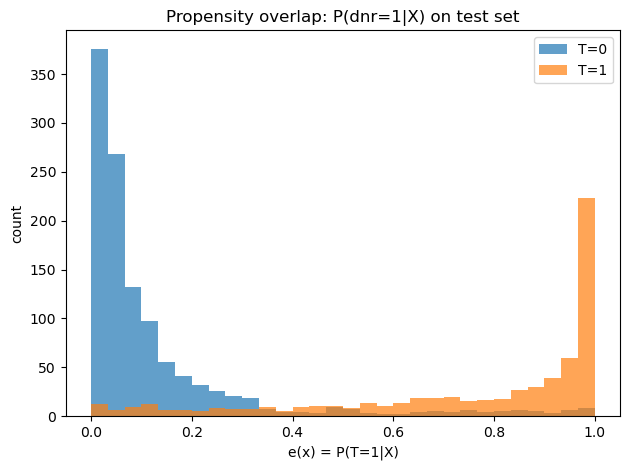

Propensity score summary: count    1.821000e+03
mean     3.558181e-01
std      3.810264e-01
min      1.362037e-08
25%      4.056139e-02
50%      1.317881e-01
75%      7.556479e-01
max      1.000000e+00
dtype: float64


In [8]:
#Cell 6: Propensity overlap diagnostics

ps = ite_model.propensity.predict_proba(X_te)

plot_overlap(ps, T_te, title="Propensity overlap: P(dnr=1|X) on test set")
plt.show()

print("Propensity score summary:", pd.Series(ps).describe())


In [9]:
# Cell 7: Counterfactual survival + ITE at a horizon (e.g., 180 days)
horizon = 180

ite = ite_model.predict_ite_survival_prob(X_te, horizon_days=horizon)
ate = ate_at_horizon(ite)

print(f"ATE at {horizon} days (Survival Prob): {ate:.4f}")
print("ITE summary:\n", pd.Series(ite).describe())


ATE at 180 days (Survival Prob): -0.2359
ITE summary:
 count    1.821000e+03
mean    -2.359374e-01
std      2.225715e-01
min     -8.924218e-01
25%     -4.053274e-01
50%     -2.115317e-01
75%     -6.348818e-24
max      1.857015e-01
dtype: float64


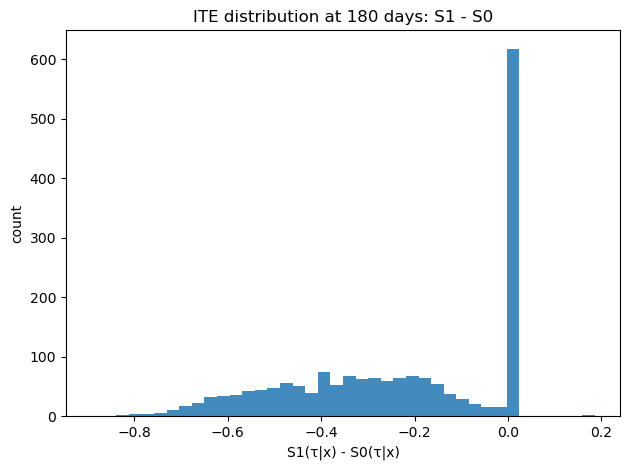

In [10]:
plot_ite_hist(ite, title=f"ITE distribution at {horizon} days: S1 - S0")
plt.show()


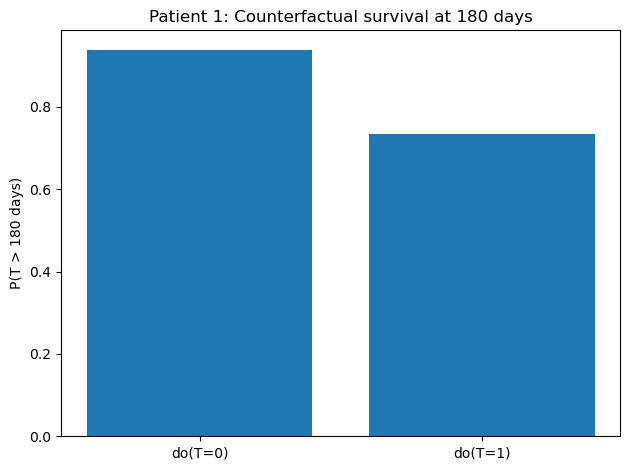

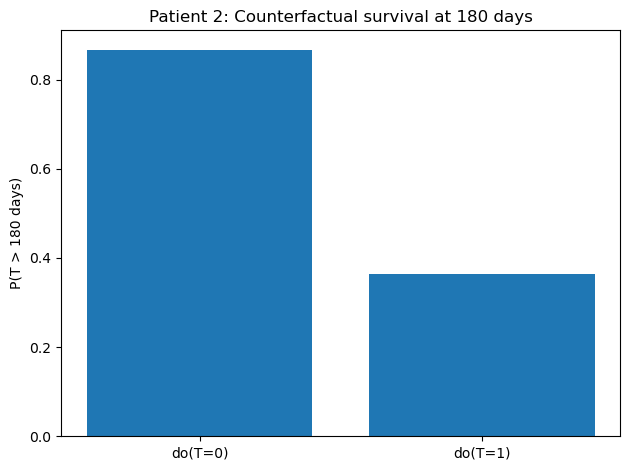

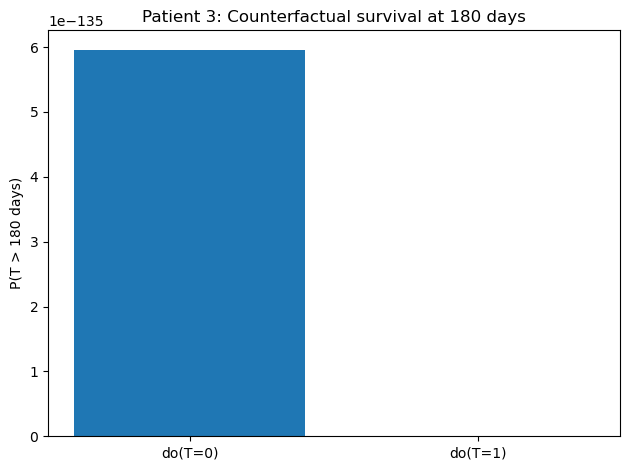

In [11]:
np.random.seed(42)
sample_idx = np.random.choice(len(X_te), size=3, replace=False)

for i, idx in enumerate(sample_idx, start=1):
    x_i = X_te.iloc[[idx]]
    s0, s1 = ite_model.predict_counterfactual_survival(x_i, horizon_days=horizon)
    plot_individual_counterfactual(float(s0[0]), float(s1[0]), horizon_days=horizon,
                                   title=f"Patient {i}: Counterfactual survival at {horizon} days")
    plt.show()


In [12]:
s0_all, s1_all = ite_model.predict_counterfactual_survival(X_te, horizon_days=horizon)

print(f"Mean P(T>{horizon}|do(dnr=0)):", float(np.mean(s0_all)))
print(f"Mean P(T>{horizon}|do(dnr=1)):", float(np.mean(s1_all)))
print(f"Mean difference (S1-S0):", float(np.mean(s1_all - s0_all)))


Mean P(T>180|do(dnr=0)): 0.5495749043558401
Mean P(T>180|do(dnr=1)): 0.3136374614006116
Mean difference (S1-S0): -0.23593744295522845
